In [1]:
from dataset import NuSceneDataset
import torch
from config import Config
import matplotlib.pyplot as plt
import pickle
import numpy as np
from model import ResNet50
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tensorboardX import SummaryWriter
import time
from torchvision import transforms

writer = SummaryWriter()
config = Config()

In [2]:
def init_optimizer(net):
    optimizer_net = optim.Adam(
        net.parameters(), config.lr, betas=(config.beta1, 0.999)
    )
    return optimizer_net

In [3]:
def save_network(net, time):
    path = './weight' + "/{}".format(time)
    if os.path.exists(path):
        pass
    else:
        os.mkdir(path)
    torch.save(net.state_dict(), path + "/checkpoint_epoch{}.pth".format(epoch))
    

epoch: 0, iter: 0, loss: 270.8765563964844


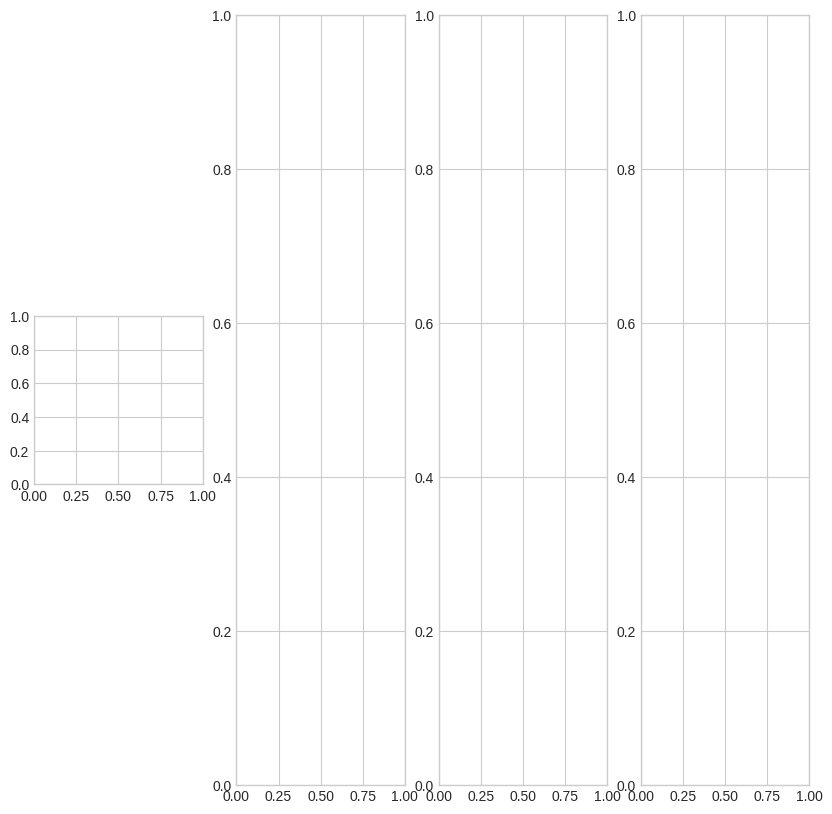

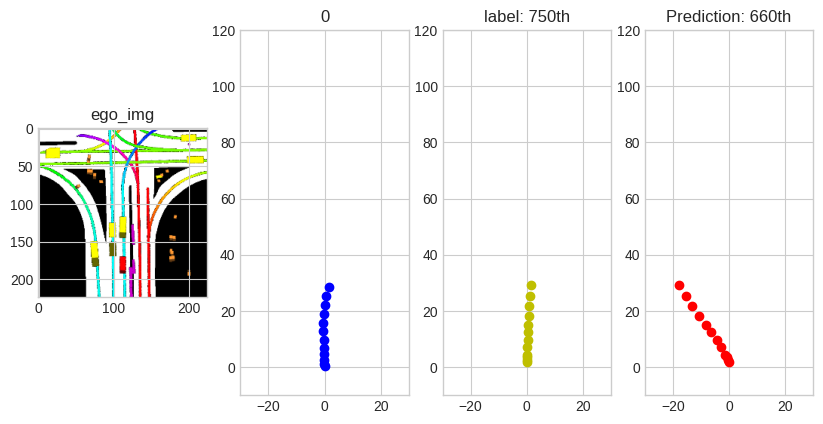

val_loss: 2663.464111328125
epoch: 0, iter: 100, loss: 609.5830688476562


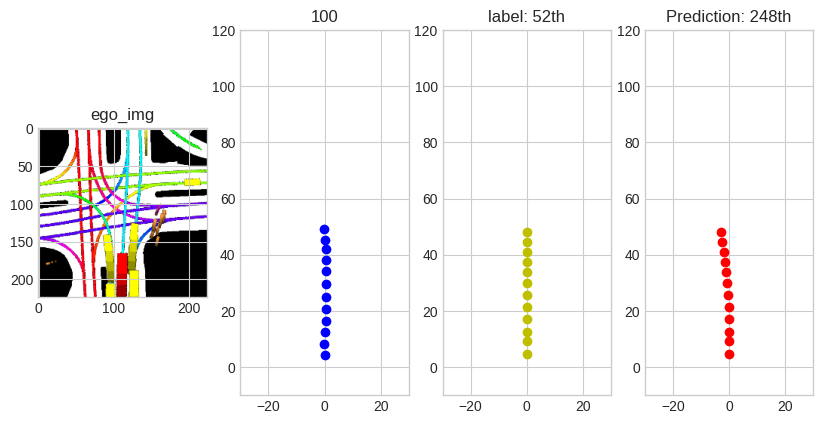

KeyboardInterrupt: 

In [7]:
train_dataset = NuSceneDataset(train_mode=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size)
val_dataset = NuSceneDataset(train_mode=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.batch_size)


traj = pickle.load(open(config.traj_set_path, 'rb'))
traj = torch.Tensor(traj)

model = models.resnet50(num_classes=len(traj)).to(config.device)

criterion1 = nn.MSELoss()
criterion = nn.CrossEntropyLoss() # Softmax 도 포함
optimizer = init_optimizer(model)
transform = transforms.Compose([transforms.Resize([224, 224])])

time_stamp = time.strftime("%Y-%m-%d %H:%M", time.localtime(time.time()))
        
for epoch in range(config.epoch):
    for i, dataset in enumerate(train_loader): # Only use ego image and label
        model.train()
        ego_img = dataset["ego_img"]
        ego_img = ego_img.permute(0,3,1,2)
        ego_img = transform(ego_img)
        ego_img = torch.div(ego_img,255)
        ego_future_hist_local = dataset["ego_future_hist_local"][0] # (1, 12, 2)
        
        label, ind_label = dataset["label"]
        
        predict = model(ego_img)
        ind_pred = torch.argmax(predict) # classification probabilities
        
        loss_class = criterion(predict, ind_label)
                
        loss_reg_tale = criterion1(traj[label[0]==1,-1,:].squeeze(0), traj[ind_pred, -1, :])
        
#         loss_reg = criterion1(traj[label[0]==1,:,:].squeeze(0), traj[ind_pred, :, :])
        
#         loss = loss_class + config.alpha *loss_reg + config.beta * loss_reg_tale

        loss = loss_class + config.alpha *loss_reg_tale
        
        writer.add_scalar("Loss", loss, epoch*len(train_loader)+i)
        
        loss.backward()
        optimizer.step()
        
        
        if (i % 100 == 0 or i == (len(train_loader)-1)): 
            print("epoch: {}, iter: {}, loss: {:.4f}".format(epoch, i, loss))
            xs = []
            ys = []
            for j in range(len(ego_future_hist_local)):
                xs.append(ego_future_hist_local[j][0].cpu())
                ys.append(ego_future_hist_local[j][1].cpu())
            xs = np.array(xs)
            ys = np.array(ys)
            
            fig, ax = plt.subplots(1,4, figsize = (10,10))
            ax[0].imshow(ego_img[0].permute(1,2,0).cpu())
            ax[0].set_title("ego_img")
            ax[1].plot(xs, ys, 'bo')
            ax[1].set_title(i)
            ax[1].set_aspect('equal')
            ax[1].set_xlim(-30, 30)
            ax[1].set_ylim(-10, 120)
            label = label.squeeze(0)
            ax[2].plot(traj[label==1,:,0] , traj[label==1,:,1],'yo')
            ax[2].set_aspect('equal')
            ax[2].set_xlim(-30,30)
            ax[2].set_ylim(-10,120)
            ax[2].set_title("label: {}th".format(ind_label[0]))
            ax[3].plot(traj[ind_pred,:,0] , traj[label==1,:,1].squeeze(0),'ro')
            ax[3].set_aspect('equal')
            ax[3].set_xlim(-30,30)
            ax[3].set_ylim(-10,120)
            ax[3].set_title("Prediction: {}th".format(ind_pred))
            plt.show()
            
            with torch.set_grad_enabled(False):
                model.eval()
                val_loss = 0
                for num, val_dataset in enumerate(val_loader):
                    ego_img = val_dataset["ego_img"]
                    ego_img = ego_img.permute(0,3,1,2)
                    ego_img = transform(ego_img)
                    ego_img = torch.div(ego_img,255)
                    ego_future_hist_local = val_dataset["ego_future_hist_local"][0] # (1, 12, 2)

                    label, ind_label = val_dataset["label"]

                    predict = model(ego_img)
                    ind_pred = torch.argmax(predict) # classification probabilities

                    loss_class = criterion(predict, ind_label)

                    loss_reg_tale = criterion1(traj[label[0]==1,-1,:].squeeze(0), traj[ind_pred, -1, :])

                    loss_temp = loss_class + config.alpha *loss_reg_tale
                    val_loss +=loss_temp
                    
                val_loss = val_loss/len(val_dataset)
                
                writer.add_scalar("Loss_val", val_loss, epoch*len(train_loader)+i)
                print("val_loss: {:.4f}".format(val_loss))
            
    save_network(model.eval(), time_stamp)
                


